## Question 1

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [25]:
# Defining the hyperparameters
hyperparams = {
    'batch_size': 100,
    'learning_rate': 0.001,
    'momentum': 0.9,
    'num_epochs': 30,
    'ewc_lambda': 1e-4
}

In [26]:
# Defining the neural network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

# Defining the forward pass of the neural network
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the neural network
net = Net()

# Defining the loss function (Cross Entropy Loss)
criterion = nn.CrossEntropyLoss()
# Defining the optimizer -Stochastic Gradient Descent with learning rate and momentum from hyperparameters
optimizer = optim.SGD(net.parameters(), hyperparams['learning_rate'], momentum=hyperparams['momentum'])


In [27]:
# Defining the data preprocessing transformations for the images
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomCrop(32, padding=4),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Loading the training data with the specified transformations and batch size
trainset = CIFAR10(root='./data', train=True,
                   download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size = hyperparams['batch_size'],
                         shuffle=True, num_workers=2)

# Loading the test data
testset = CIFAR10(root='./data', train=False,
                  download=True, transform=transform)
testloader = DataLoader(testset, batch_size = hyperparams['batch_size'],
                        shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [28]:
# Defining the EWC regularization function
def ewc_regularizer(net, ewc_weights, ewc_fisher, lam=1e-4):
    # Initializing the regularization loss to zero
    reg_loss = 0
    # Looping through the named parameters of the network
    for name, param in net.named_parameters():
        if name in ewc_weights:
            reg_loss += (ewc_fisher[name] * (param - ewc_weights[name]) ** 2).sum()
    # Multiplying the regularization loss by the regularization strength and return        
    return lam * 0.5 * reg_loss


In [29]:
# Defining the function to compute Fisher Information for each parameter in the network
def compute_fisher(net, data_loader):
    fisher = {}
    for name, param in net.named_parameters():
        fisher[name] = torch.zeros_like(param)

    net.eval()

    # Looping through the data loader and accumulate gradients squared for each named parameter
    for inputs, labels in data_loader:
        inputs, labels = Variable(inputs), Variable(labels)
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        for name, param in net.named_parameters():
            fisher[name] += (param.grad ** 2) / len(data_loader)

    net.train()
    # Returning the dictionary of Fisher Information tensors
    return fisher

In [30]:
# Evaluation function
def evaluate(net, dataloader, criterion):
    net.eval()
    running_loss = 0.0
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    return running_loss / len(dataloader)

# Initializing empty lists to store training and test losses
train_losses = []
test_losses = []

# Initializing empty dictionaries for EWC weights and Fisher Information
ewc_weights = {}
ewc_fisher = {}

# Looping through the specified number of epochs
for epoch in range(hyperparams['num_epochs']):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        # Applying EWC regularization
        if epoch > 0:
            ewc_reg = ewc_regularizer(net, ewc_weights, ewc_fisher)
            loss += ewc_reg
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Calculateing and storing the average training loss for the epoch
    train_loss = running_loss / (i + 1)
    train_losses.append(train_loss)
    
    # Calculating and storing the test loss 
    test_loss = evaluate(net, testloader, criterion)
    test_losses.append(test_loss)
    
    print(f'Epoch {epoch + 1}, Loss: {running_loss / (i + 1)}')

    # Updating the EWC weights and Fisher information after each epoch
    for name, param in net.named_parameters():
        ewc_weights[name] = param.clone().detach()
    ewc_fisher = compute_fisher(net, trainloader)


Epoch 1, Loss: 2.3022911162376403
Epoch 2, Loss: 2.29245564699173
Epoch 3, Loss: 2.2285939865112305
Epoch 4, Loss: 2.1280582611560823
Epoch 5, Loss: 2.0127363023757936
Epoch 6, Loss: 1.9120361053943633
Epoch 7, Loss: 1.8098482763767243
Epoch 8, Loss: 1.7455619170665742
Epoch 9, Loss: 1.7033523836135864
Epoch 10, Loss: 1.6653547360897065
Epoch 11, Loss: 1.6274724435806274
Epoch 12, Loss: 1.5993130044937134
Epoch 13, Loss: 1.5799663684368133
Epoch 14, Loss: 1.5523484404087067
Epoch 15, Loss: 1.5285183272361755
Epoch 16, Loss: 1.5104207348823548
Epoch 17, Loss: 1.49433509349823
Epoch 18, Loss: 1.4674811301231385
Epoch 19, Loss: 1.4529520049095155
Epoch 20, Loss: 1.4360059406757355
Epoch 21, Loss: 1.414236671447754
Epoch 22, Loss: 1.407372528553009
Epoch 23, Loss: 1.3948343124389648
Epoch 24, Loss: 1.3740547997951507
Epoch 25, Loss: 1.365507165670395
Epoch 26, Loss: 1.3525623840093612
Epoch 27, Loss: 1.3389750339984894
Epoch 28, Loss: 1.3261827790737153
Epoch 29, Loss: 1.3170118508338928
E

NameError: ignored

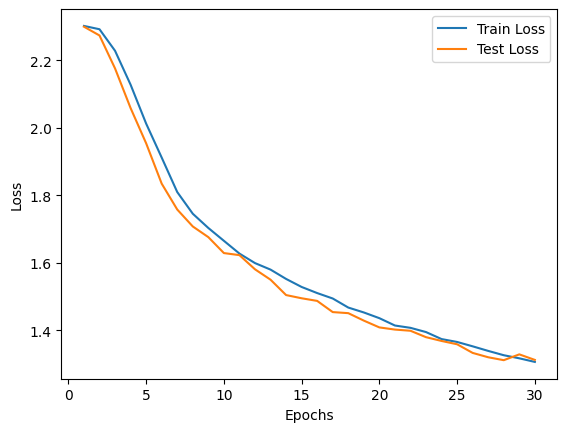

In [32]:
# Plotting the training and testing losses
plt.plot(range(1, hyperparams['num_epochs'] + 1), train_losses, label='Train Loss')
plt.plot(range(1, hyperparams['num_epochs'] + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Question 2

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [12]:
data = load_breast_cancer()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Converting data to PyTorch tensors
X_train, X_test = torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32)
y_train, y_test = torch.tensor(y_train, dtype=torch.long), torch.tensor(y_test, dtype=torch.long)

# Creating a simple feedforward neural network
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out


# This is the continuous learning model with Elastic Weight Consolidation
    def __init__(self, model, ewc_lambda=10000):
        self.model = model
        self.ewc_lambda = ewc_lambda
        self.params = {n: p for n, p in self.model.named_parameters() if p.requires_grad}
        self._means = {}
        self._precision_matrices = self._initialize_fisher()

    def _initialize_fisher(self):
        return {n: p.clone().zero_() for n, p in self.params.items()}

    def _update_fisher(self, X, y):
        self.model.train()
        for x, t in zip(X, y):
            self.model.zero_grad()
            output = self.model(x.unsqueeze(0))
            loss = F.cross_entropy(output, t.unsqueeze(0))
            loss.backward()
            for n, p in self.model.named_parameters():
                if p.grad is not None:
                    self._precision_matrices[n].add_(p.grad.data ** 2)

    def _estimate_fisher(self, X, y):
        self._update_fisher(X, y)
        for n, p in self._precision_matrices.items():
            p.div_(X.size(0))

    def update_means_params(self, X, y):
        self.model.train()
        for n, p in self.params.items():
            self._means[n] = p.clone().detach()
        self._estimate_fisher(X, y)

    def penalty(self):
        loss = 0
        for n, p in self.model.named_parameters():
          if n in self._means:
            _loss = self._precision_matrices[n] * (p - self._means[n]) ** 2
            loss += _loss.sum()
        return loss * self.ewc_lambda

# Setting up training settings
input_size = X_train.shape[1]
hidden_size = 128
num_classes = 2
num_epochs = 100
batch_size = 16
learning_rate = 0.005
ewc_lambda = 10000

# Initializing the model, loss function, and optimizer
model = SimpleNN(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
ewc = EWC(model, ewc_lambda)

# Creating DataLoaders
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


training_losses = []
# Training the model
for epoch in range(num_epochs):
    epoch_loss = 0
    for i, (inputs, targets) in enumerate(train_loader):
        model.train()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Adding EWC penalty
        ewc_penalty = ewc.penalty()
        total_loss = loss + ewc_penalty

        # Accumulating the loss for this epoch
        epoch_loss += total_loss.item()

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

    # Calculating the average loss for this epoch
    epoch_loss /= len(train_loader)

    # Appending the average loss to the list of training losses
    training_losses.append(epoch_loss)

    # Updating EWC means and precision matrices
    ewc.update_means_params(X_train, y_train)

    # epoch_loss += total_loss.item()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

# Evaluating the model
model.eval()
with torch.no_grad():
    outputs = model(X_test)
    _, predicted = torch.max(outputs.data, 1)

# Calculating accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, predicted)
precision = precision_score(y_test, predicted)
recall = recall_score(y_test, predicted)
f1 = f1_score(y_test, predicted)

# Printing results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Epoch [10/100], Loss: 2.5357
Epoch [20/100], Loss: 0.0208
Epoch [30/100], Loss: 0.7052
Epoch [40/100], Loss: 0.8179
Epoch [50/100], Loss: 0.0265
Epoch [60/100], Loss: 0.0618
Epoch [70/100], Loss: 0.3180
Epoch [80/100], Loss: 0.1612
Epoch [90/100], Loss: 0.1386
Epoch [100/100], Loss: 0.0681
Accuracy: 0.97
Precision: 0.96
Recall: 1.00
F1 Score: 0.98


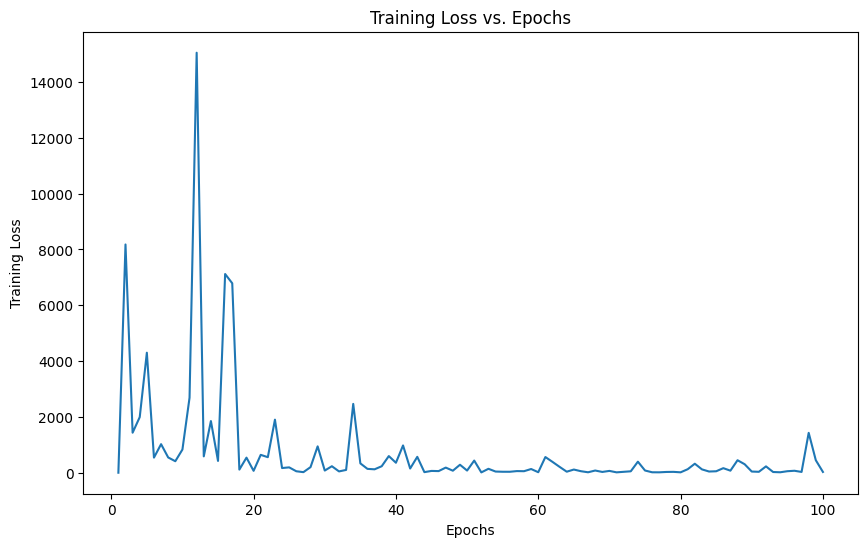

In [13]:
# Plotting the training loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), training_losses)
plt.title('Training Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.show()

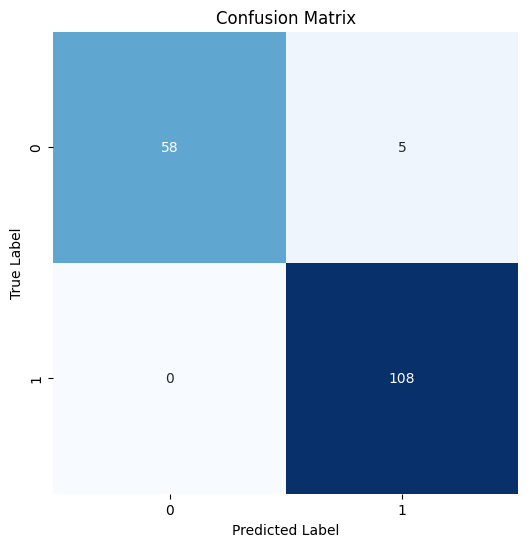

In [14]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predicted)

# Plotting the confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Observation 

A few observations - 

1. The loss fluctuates over the epochs. This might suggest that the learning rate is too high, causing the optimizer to overshoot the optimal weights. To address this, we can try decreasing the learning rate or using learning rate schedulers or we can train the model for more epochs until the fluctuations become stable. 

2. The model's overall performance is good but it is good to monitor the model for overfitting. This can be done by evaluating the model on a separate validation set during training and comparing the performance on the training and validation sets. If a significant gap is observed, regularization techniques like dropout, L1/L2 regularization can be applied to prevent overfitting.

3. The Elastic Weight Consolidation lambda parameter could also be tuned. It determines the balance between the task-specific loss and the EWC penalty. A higher value places more emphasis on the EWC penalty, while a lower value focuses more on the task-specific loss. You can experiment with different values for EWC lambda to find the optimal balance.

4. The model's performance is quite good, with an accuracy of 0.97, precision of 0.96, recall of 1.00, and an F1 score of 0.98. These metrics indicate that the model is doing well in both identifying positive cases and avoiding false positives (high precision). The high F1 score suggests that there is a good balance between precision and recall.